## Results Journal

This notebook will take the outputs of the GAM fitting scripts to answer the following questions:

1. Which level of temporal resolution of temperature and precipitation data is best able to predict mosquito abundances?

2. How consistantly can temporal lags and significant meteorological drivers be characterised for species specific abundance models across multiple locations?

These two questions form the basis of my investigation and should help to inform appropriate development of early warning models of vector-borne disease. 

In [27]:
# First load necessary packages and source files
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))
source("../Code/gam_functions.R")

# Define colorblind friendly palette
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

# from https://jfly.uni-koeln.de/color/


## Datasets

Datasets are compiled into three seperate temporal resolution groups: weekly, bimonthly, and monthly data. Each of these are stored in a different csv. We will use comparisons of these three groups to answer question \#1


In [2]:
# Load in datasets
weekly = read.csv('../Results/GAM_weekly.csv', header = T, stringsAsFactors = F)
biweekly = read.csv('../Results/GAM_biweekly.csv', header = T, stringsAsFactors = F)
monthly = read.csv('../Results/GAM_monthly.csv', header = T, stringsAsFactors = F)


In [3]:
cat("There are ", dim(weekly)[1], " rows in the weekly dataframe\n")
cat("There are ", dim(biweekly)[1], " rows in the biweekly dataframe\n")
cat("There are ", dim(monthly)[1], " rows in the monthly dataframe\n")

There are  161  rows in the weekly dataframe
There are  161  rows in the biweekly dataframe
There are  161  rows in the monthly dataframe


# Remove datasets

At some point, abundance time series with too many zero values no longer indicate abundance *dynamics* but rather random detection of small population sizes. Perhaps we catch very few of these species because the trap type is not specialised for their life history. Perhaps traps are not normally placed in areas this species frequents. Perhaps this species is present only in very low numbers. I chose to cut out datasets with fewer than 10% non zero values because of these potential data *quality* issues arising from the limitations of data collection by trapping methods.

In [4]:
wk_0 = weekly %>% filter(z_inflation_pct > 90.0 | is.na(z_inflation_pct)) %>% nrow()
bwk_0 = biweekly %>% filter(z_inflation_pct > 90.0 | is.na(z_inflation_pct)) %>% nrow()
mnth_0 = monthly %>% filter(z_inflation_pct > 90.0 | is.na(z_inflation_pct)) %>% nrow()

cat("There are ", wk_0, " rows with less than 10% nonzero values in the weekly dataframe\n")
cat("There are ", bwk_0, " rows with less than 10% nonzero values in the biweekly dataframe\n")
cat("There are ", mnth_0, " rows with less than 10% nonzero values in the monthly dataframe\n")

There are  50  rows with less than 10% nonzero values in the weekly dataframe
There are  42  rows with less than 10% nonzero values in the biweekly dataframe
There are  32  rows with less than 10% nonzero values in the monthly dataframe


In order to have 3 comporable temporal resolution groups, the weekly, bimonthly, and monthly resolution groups must contain the same species and location datasets. I will remove any datasets that do not have equivalent versions in all of the data groups.

In [5]:
remove = c(which(is.na(weekly$Multi_DevianceExplained)), which(is.na(biweekly$Multi_DevianceExplained)), which(is.na(monthly$Multi_DevianceExplained)))

weekly = weekly[-remove,]
biweekly = biweekly[-remove,]
monthly = monthly[-remove,]

In [6]:
# Ensure every aggregation has the same number of datasets
cat("There are ", dim(weekly)[1], " rows in the weekly dataframe\n")
cat("There are ", dim(biweekly)[1], " rows in the biweekly dataframe\n")
cat("There are ", dim(monthly)[1], " rows in the monthly dataframe\n")

There are  110  rows in the weekly dataframe
There are  110  rows in the biweekly dataframe
There are  110  rows in the monthly dataframe


## Visualize Zero Inflation

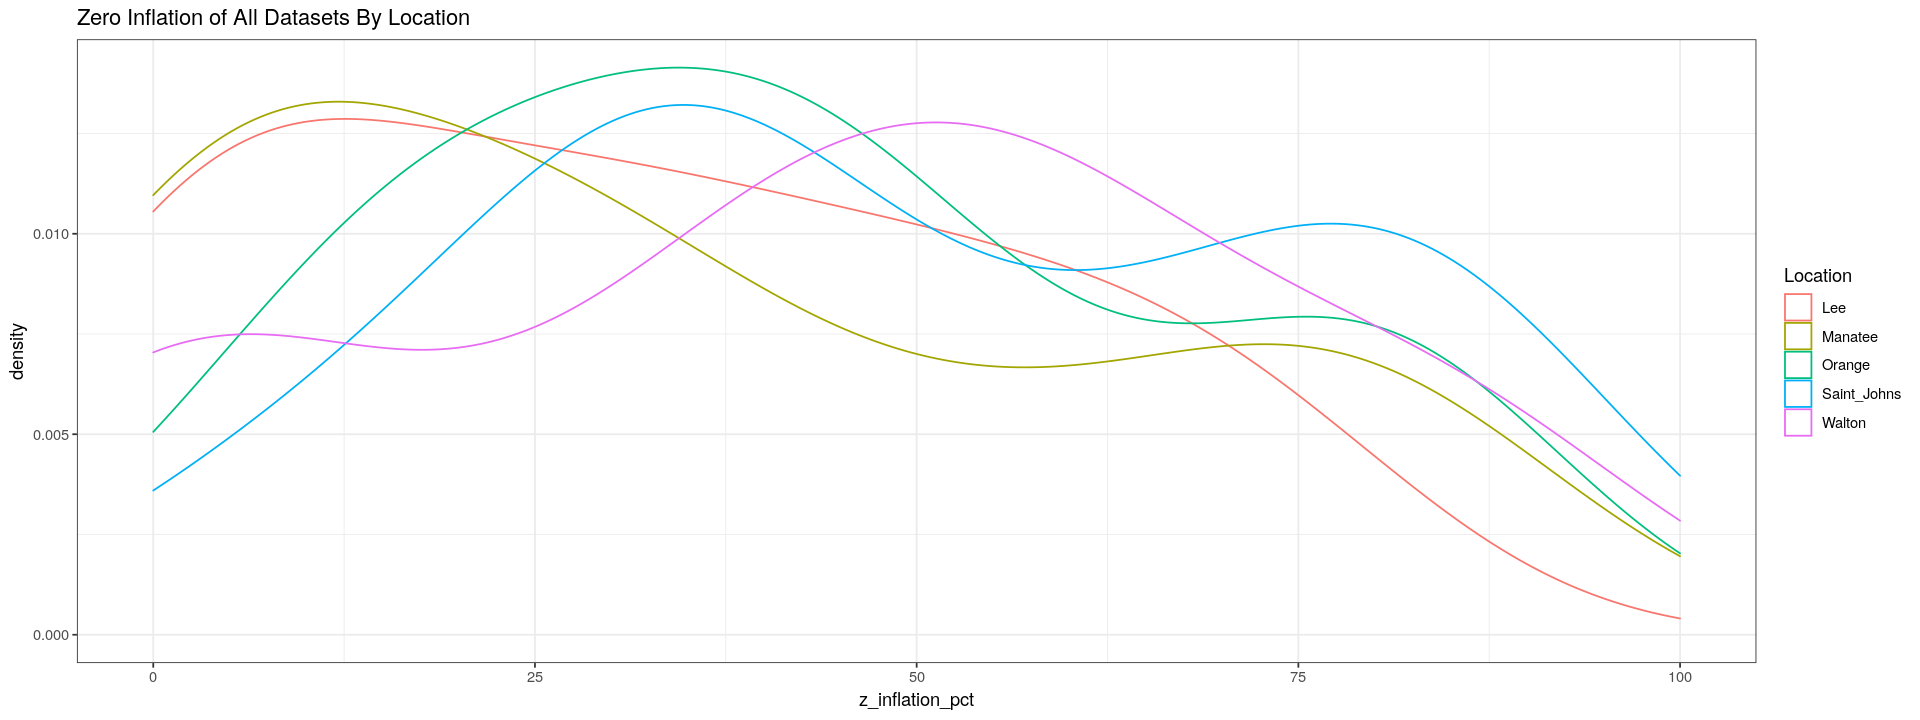

In [7]:
options(repr.plot.width=16, repr.plot.height=6)
ggplot(weekly, aes(x = z_inflation_pct, color = Location)) + geom_density(alpha = 0.3) + theme_bw() +
ggtitle("Zero Inflation of All Datasets By Location") + xlim(c(0,100))


I want to explore the number of non-zero observations in the best fit datasets by location

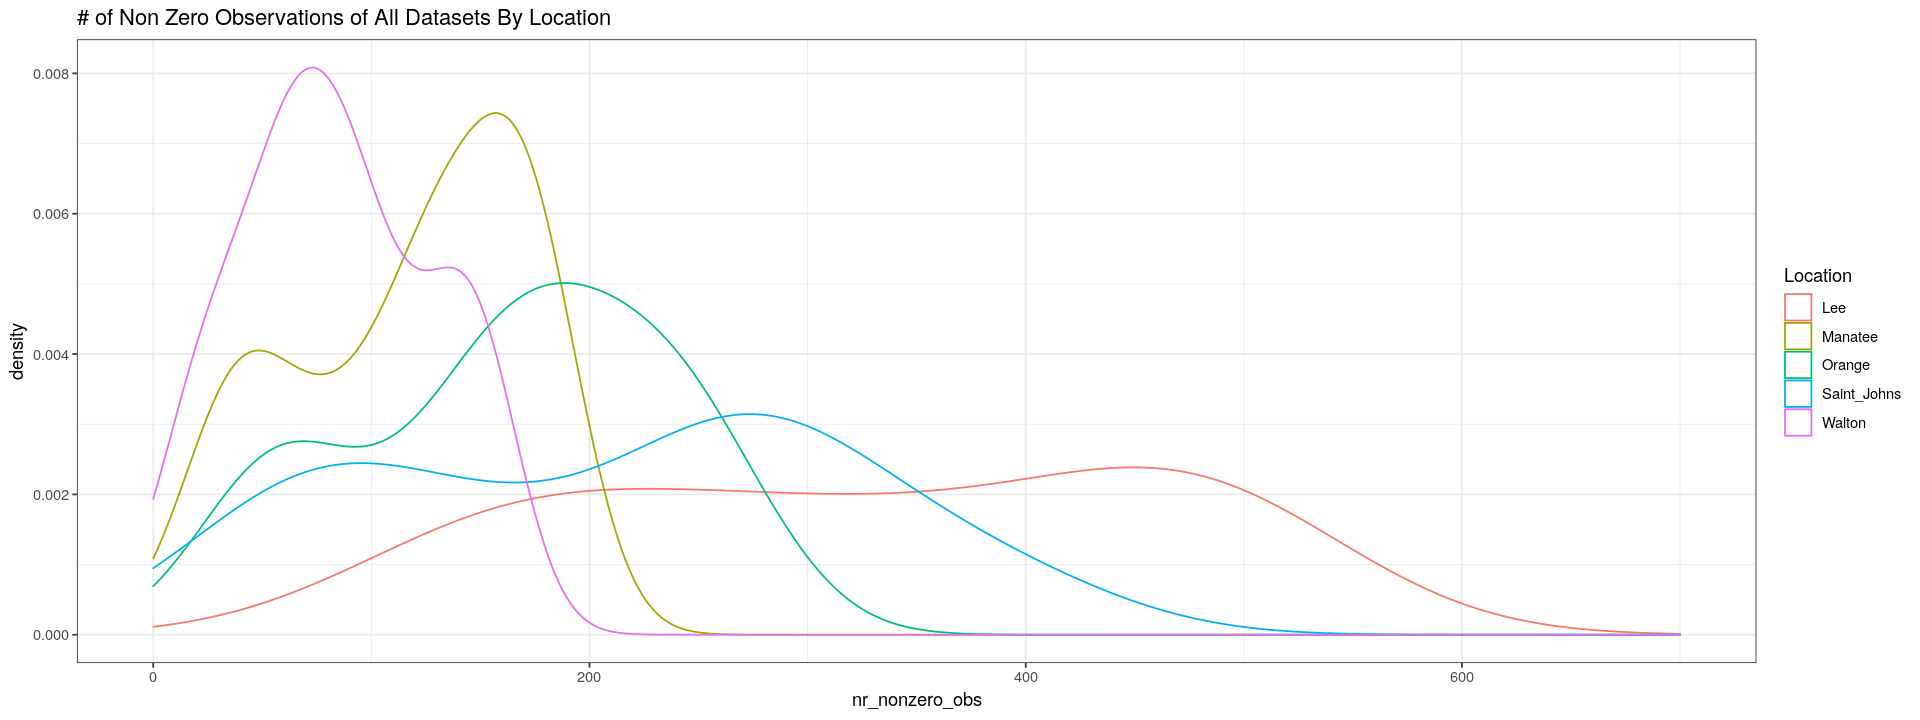

In [8]:
options(repr.plot.width=16, repr.plot.height=6)
ggplot(weekly, aes(x = nr_nonzero_obs, color = Location)) + geom_density(alpha = 0.3) + theme_bw() +
ggtitle("# of Non Zero Observations of All Datasets By Location") + xlim(0, 700)

## Table 1: Deviance explained and Mean Absolute Error

Deviance explained and Mean Absolute Error (MAE) are measures of model fit and prediction error, respectively. A high deviance explained means the model does a good job of explaining the variation in the data. MAE, in contrast, is a powerful way to compare the *predictive*, rather than simply descriptive power of a model. It is an absolute measure of the average number of mosquitoes by which model predictions are "off" by when compared in the block cross validation I used for my methods. Please see my report for more details. 

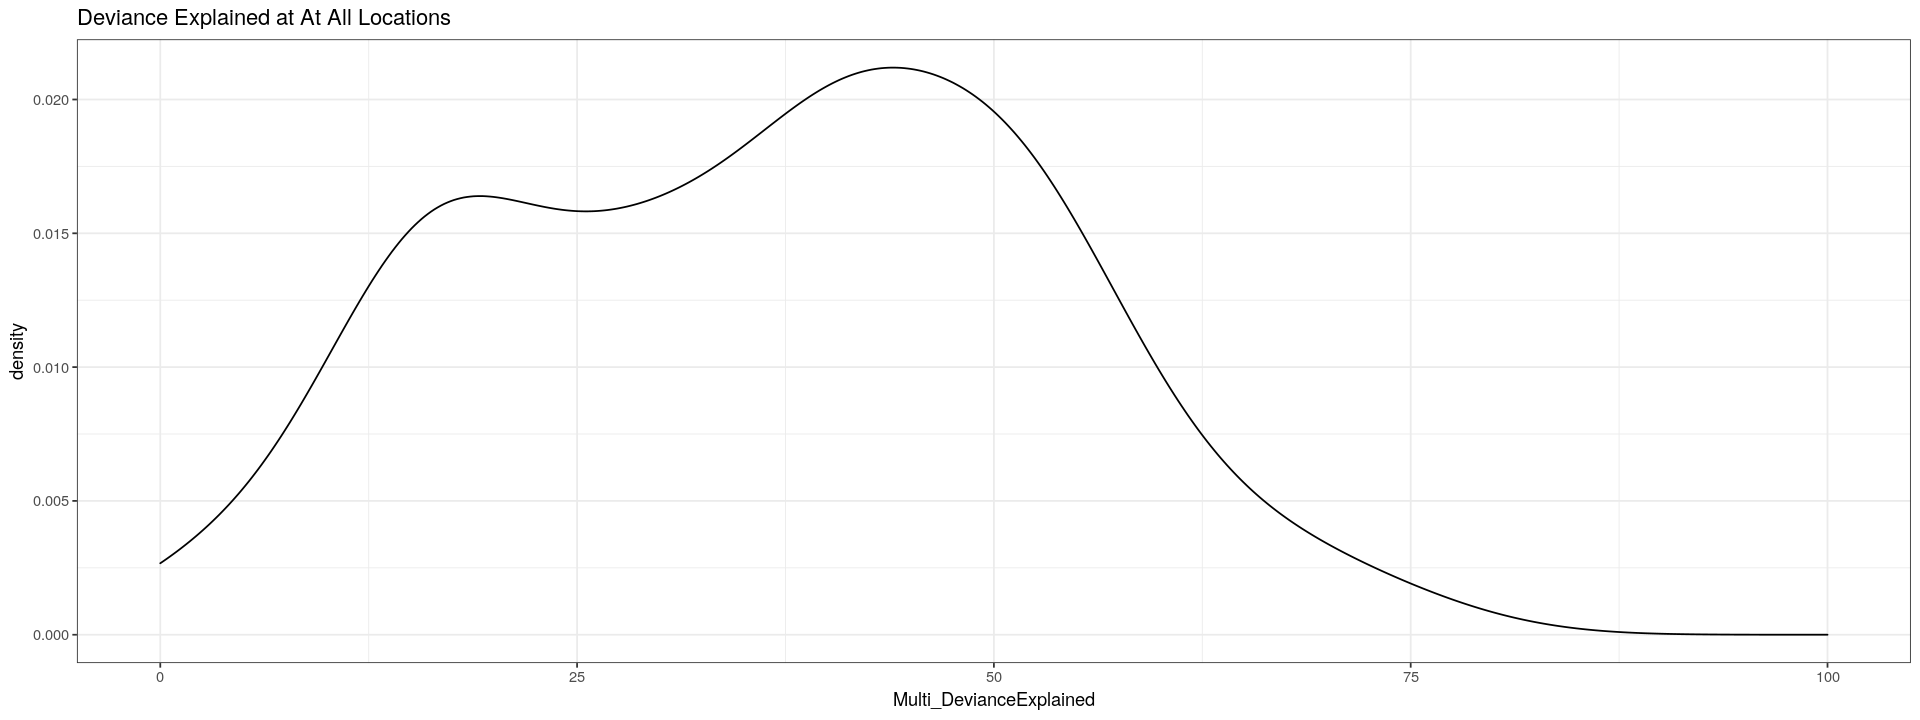

In [9]:
# Visualise the distribution of deviance explained across all locations

options(repr.plot.width=16, repr.plot.height=6)
ggplot(biweekly, aes(x = Multi_DevianceExplained)) + geom_density(alpha = 0.3) + 
theme_bw() + xlim(0,100) + ggtitle("Deviance Explained at At All Locations") 


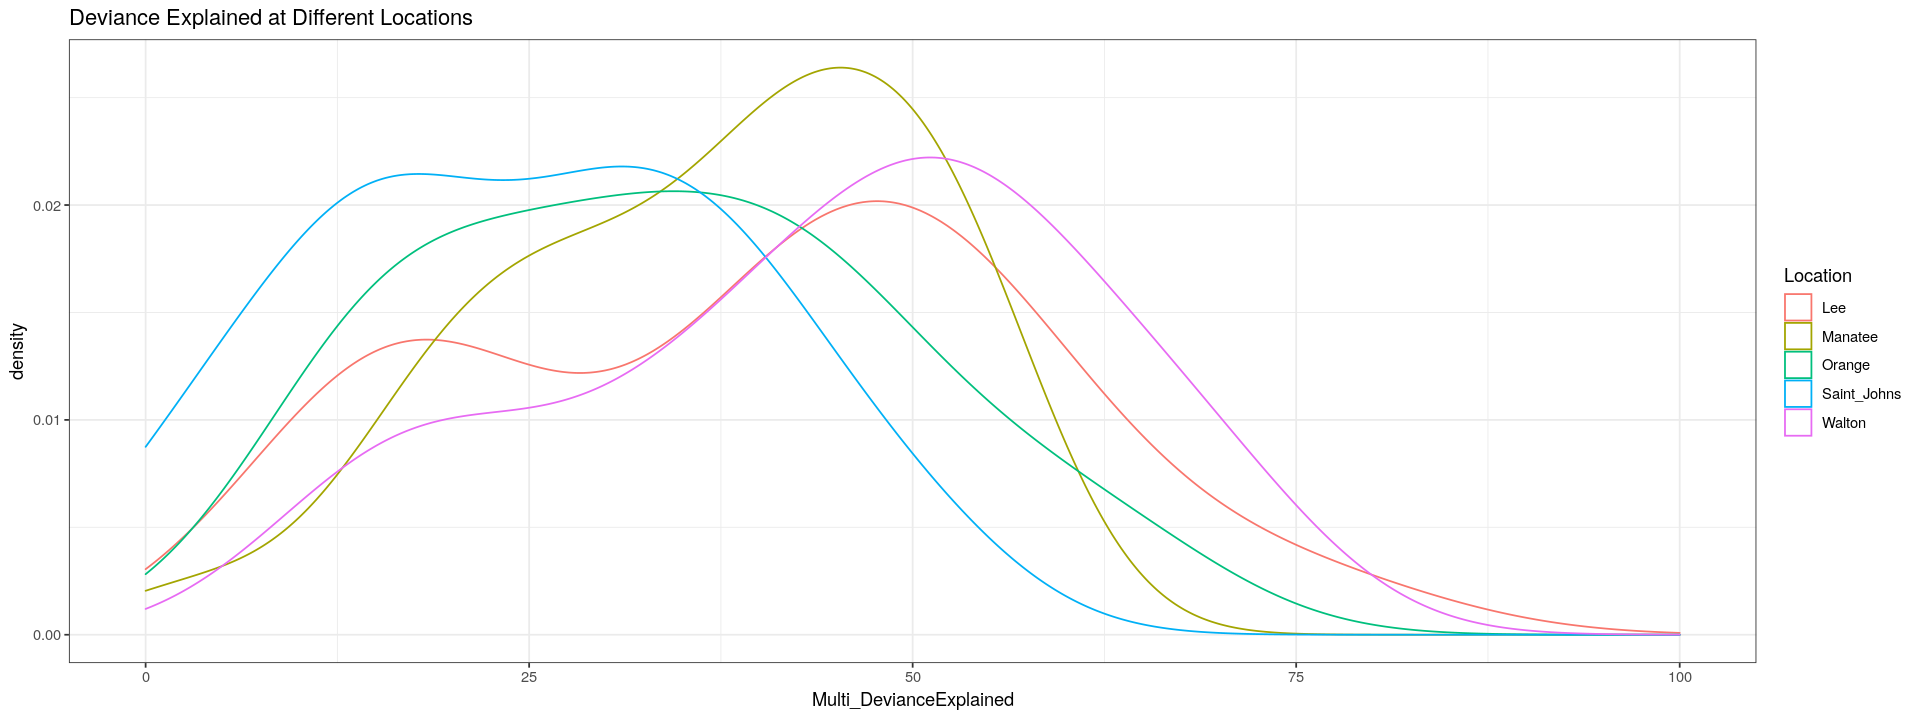

In [10]:
# Visualise the distribution of deviance explained at each location

options(repr.plot.width=16, repr.plot.height=6)
ggplot(biweekly, aes(x = Multi_DevianceExplained, color = Location)) + geom_density(alpha = 0.3) + 
theme_bw() + xlim(0,100) + ggtitle("Deviance Explained at Different Locations")

Warning message:
“Removed 11 rows containing non-finite values (stat_density).”


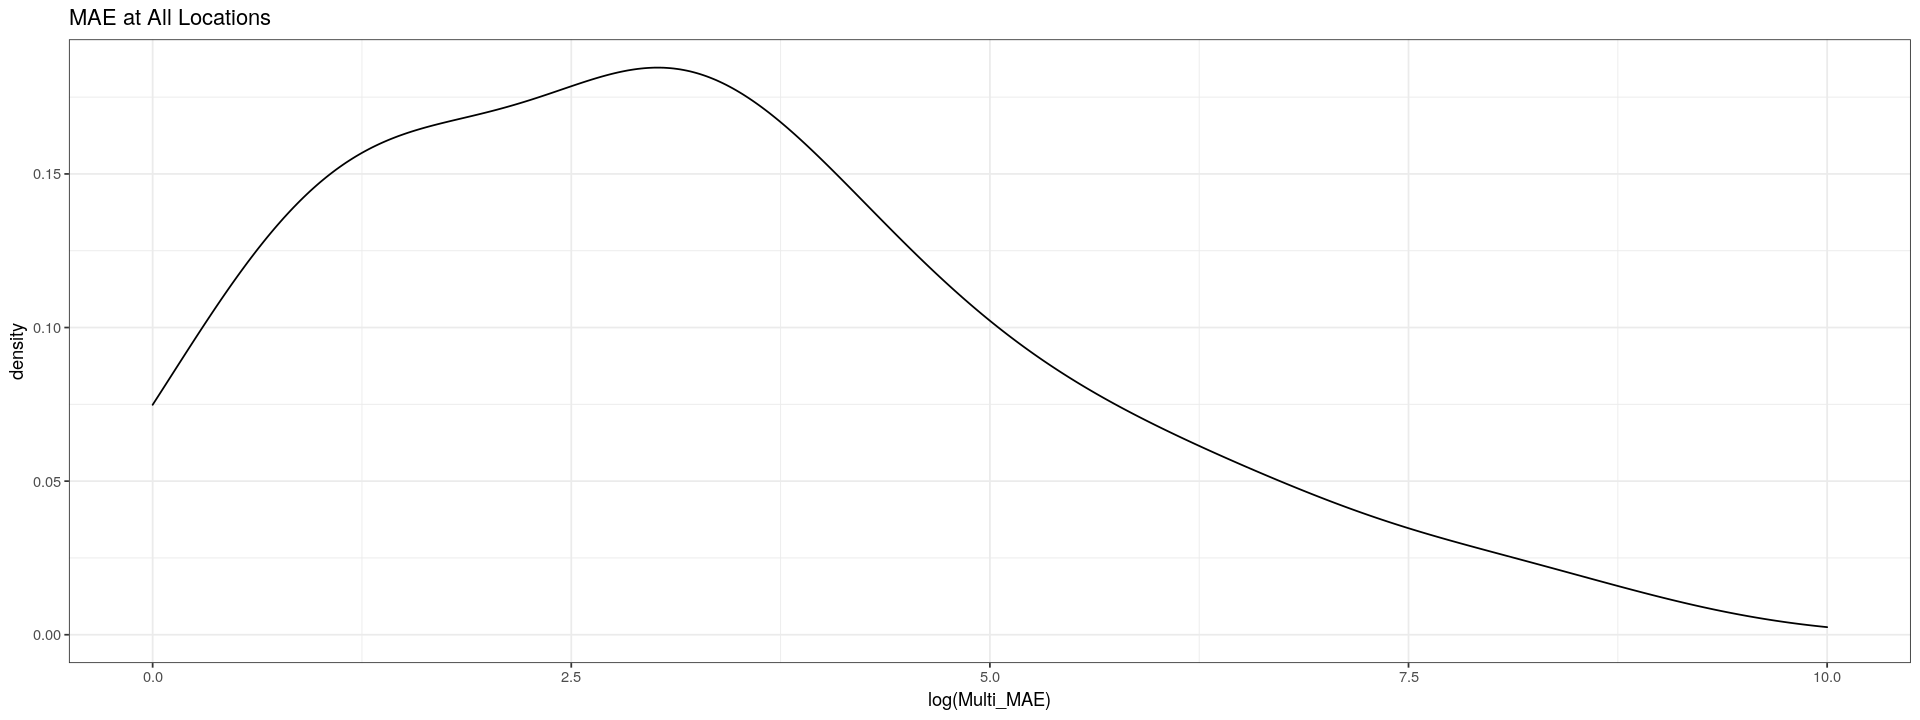

In [11]:
# Visualize the distribution of MAE at all locations:

options(repr.plot.width=16, repr.plot.height=6)
ggplot(biweekly, aes(x = log(Multi_MAE))) + geom_density(alpha = 0.3) + 
theme_bw() + ggtitle("MAE at All Locations") + xlim(0,10)

Warning message:
“Removed 11 rows containing non-finite values (stat_density).”


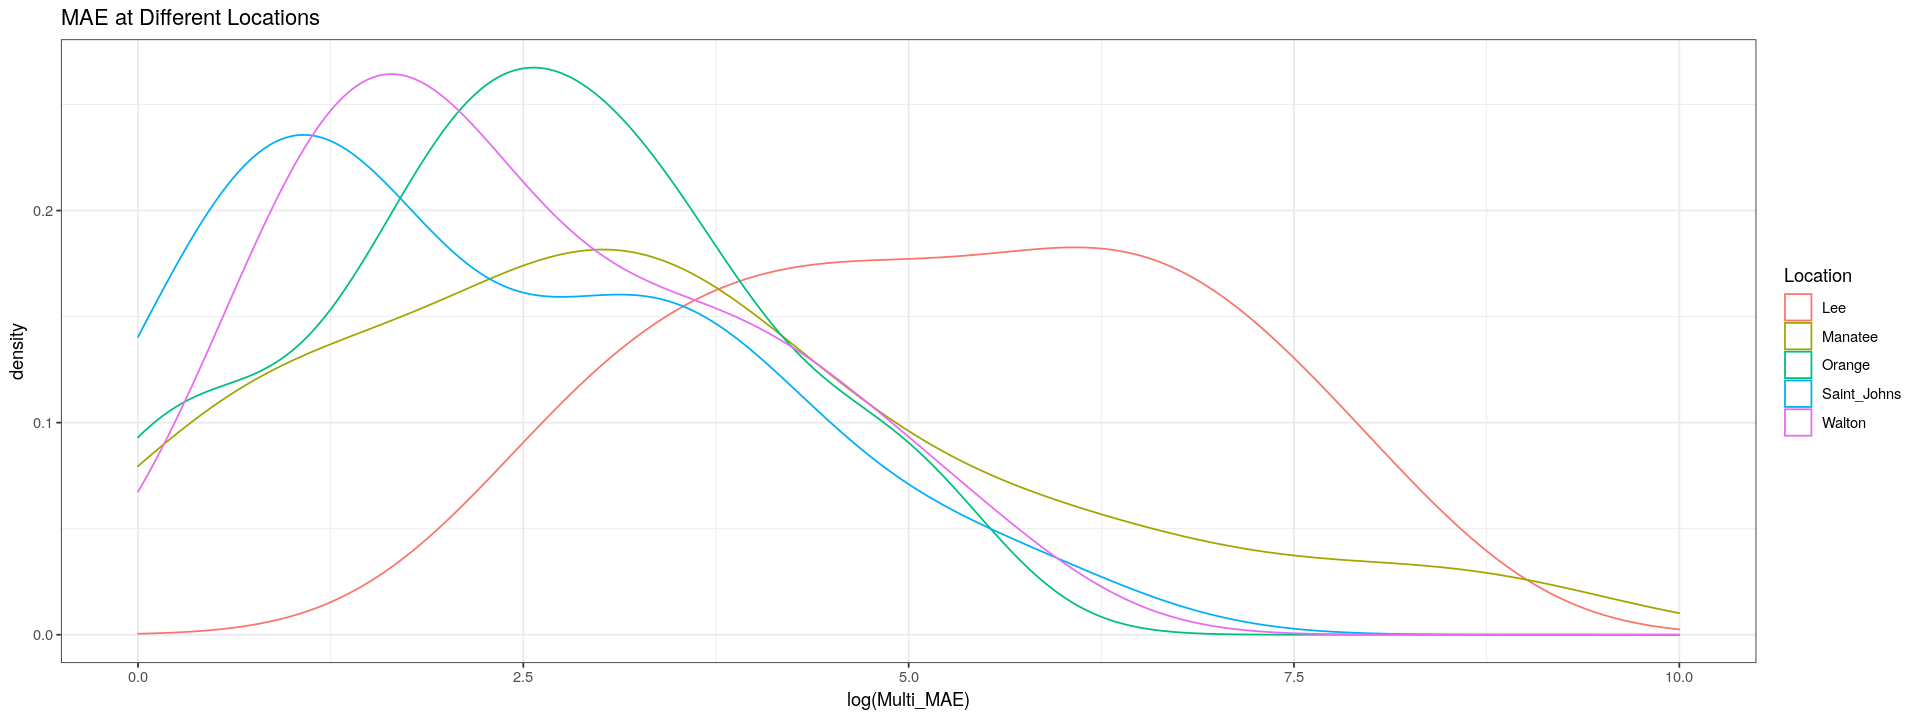

In [12]:
# Visualize the distribution of MAE at each location:

options(repr.plot.width=16, repr.plot.height=6)
ggplot(biweekly, aes(x = log(Multi_MAE), color = Location)) + geom_density(alpha = 0.3) + 
theme_bw() + ggtitle("MAE at Different Locations") + xlim(0,10) 

## Table 2

Create analysis for Table 2 in Results: this table answers the first question, "Which level of temporal resolution of temperature and precipitation data is best able to predict mosquito abundances?". Medians of each category will be used since distributions are skewed. 


In [13]:
locations = sort(unique(weekly$Location))

table1 = matrix(NA, ncol = 4, nrow = 6)

for(j in 1:length(locations)){
    table1[j,1] = locations[j]
    table1[j,2] = median(weekly$Multi_DevianceExplained[which(weekly$Location == locations[j])])
    table1[j,3] = median(biweekly$Multi_DevianceExplained[which(biweekly$Location == locations[j])])
    table1[j,4] = median(monthly$Multi_DevianceExplained[which(monthly$Location == locations[j])])                      
}

table1[6,1] = "Total"
table1[6,2] = median(weekly$Multi_DevianceExplained)
table1[6,3] = median(biweekly$Multi_DevianceExplained)
table1[6,4] = median(monthly$Multi_DevianceExplained)


table1 = data.frame(table1)
colnames(table1) = c("Location", "Weekly", "Biweekly", "Monthly")

table2 = matrix(NA, ncol = 4, nrow = 6)

# Do the same table but for MAAPE
for(j in 1:length(locations)){
    table2[j,1] = locations[j]
    table2[j,2] = round(median(weekly$Multi_MAE[which(weekly$Location == locations[j])]),2)
    table2[j,3] = round(median(biweekly$Multi_MAE[which(biweekly$Location == locations[j])]),2)
    table2[j,4] = round(median(monthly$Multi_MAE[which(monthly$Location == locations[j])]),2) 
}

table2[6,1] = "Total"
table2[6,2] = round(median(weekly$Multi_MAE, na.rm = T),2)
table2[6,3] = round(median(biweekly$Multi_MAE, na.rm = T),2)
table2[6,4] = round(median(monthly$Multi_MAE, na.rm = T),2)


table2 = data.frame(table2)
colnames(table2) = c("Location", "Weekly", "Biweekly", "Monthly")


cat("\n Median Deviance Explained at Each Location \n\n")
print(table1)

cat("\n\n\n Median MAE at Each Location \n\n")
print(table2)


 Median Deviance Explained at Each Location 

     Location Weekly Biweekly Monthly
1         Lee  35.25     42.3   45.85
2     Manatee   32.9     40.4    41.2
3      Orange  29.65     32.2    36.8
4 Saint_Johns   19.5     26.1    23.8
5      Walton  40.85     47.7   48.05
6       Total  31.45    38.65    40.8



 Median MAE at Each Location 

     Location Weekly Biweekly Monthly
1         Lee 450.35   207.85   97.38
2     Manatee  40.44    18.25   10.31
3      Orange  32.09    12.51    5.89
4 Saint_Johns    7.5     3.46    1.74
5      Walton  12.07     5.59    2.18
6       Total  38.99    17.07    8.27


In most locations, deviance explained is highest in the monthly aggregated data and in all locations, MAE is lowest in monthly aggregated data. This suggests that monthly resolutions are the best fit and most predictive models. But why? Let's compare the fit of some monthly versus weekly data. 

In [14]:
# First define function that will plot predicted versus actual data
create_plotting_set = function(locale, scale, pick_spec){
  # Load output data
  output = read.csv(file = paste0("../Results/GAM_", scale, ".csv"), header = TRUE, stringsAsFactors = FALSE)
  
  # Load dataset with time series data
  ts_data = read.csv(file = paste0("../Data/Extracted_Data/Aggregated/", locale, "_", scale, ".csv"), header = TRUE, stringsAsFactors = FALSE)
  
  species = colnames(ts_data[10:(dim(ts_data)[2]-3)])
  
  # Create vectors identifying the lags at this temporal scale
  lags = make_laglists(scale = scale)
  
  # Create a data frame of lagged meteorological values
  lag_table = make_lag_table(temp = ts_data$temp_mean, precip = ts_data$precip_days, lags = lags)
  
  # Pick a species
  i = which(species == pick_spec)
  
  # Find row index in output
  output_index = which(output$Species == pick_spec & output$Location == locale)
  
  # Prepare x and y variables. We'll use the best fit lags of temp and precip for each species 
  vars = prep_variables(temp = lag_table[[output$Best_Temp[output_index]]], 
                        precip = lag_table[[output$Best_Precip[output_index]]], 
                        abundance = ts_data[[species[i]]], years = ts_data$Year, caldates = ts_data$date)
  
  # Max number of basis splines is = to the number of unique data points (discrete days of rainfall) 
  # Thus max k (number of knots) is equal to nr of unique values + 1. 
  # Default will be 10, but datasets with fewer unique values 9 than this will be adjusted accordingly
  precip_k = 10
  if(length(unique(vars$precip)) < 10){precip_k = length(unique(vars$precip))}
  
  # Create a vector of unique years
  yrs = unique(vars$years)
  
  # Create empty vectors to store fit values
  predicted = vector()
  upperCI = vector()
  lowerCI = vector()
  
  for(i in 1:length(yrs)){
    
    train = vars[which(vars$years != yrs[i]),]; test = vars[which(vars$years == yrs[i]),]
    test_gam = gam(abundance ~ s(temp, bs = 'cr', k = 10) + s(precip, k = precip_k, bs = 'cr'), data = train, family = tw, method = "REML", select = TRUE)
    
    # Find p value of this gam (power index)
    p = as.numeric(str_extract(pattern = "[0-9]\\.[0-9]*", summary(test_gam)$family$family))
    
    # Evaluate deviance explained for validation set
    fam = tw(link = "log", theta = p, a = 1.0, b = 2.0)
    
    y = test$abundance; w = y*0+1
    mu = predict(test_gam, test, type = "response", se.fit = TRUE)
    
    # Find confidence intervals
    # More in depth: Bayesian credible intervals: https://fromthebottomoftheheap.net/2016/12/15/simultaneous-interval-revisited/
    upper =  mu$fit + (2 * mu$se.fit)
    lower =  mu$fit - (2 * mu$se.fit)
    
    # Append these calculations to the running list of fit values
    predicted = c(predicted, mu$fit)
    upperCI = c(upperCI, upper)
    lowerCI = c(lowerCI, lower)
    
  }
  
  # Add predicted values to variables data frame
  vars = bind_cols(vars, predicted = predicted, upperCI = upperCI, lowerCI = lowerCI)
  
  # create a dataframe for plotting:
  plot_frame = data.frame("date" = ts_data$date, "year" = ts_data$Year, "predicted" = rep(NA, nrow(ts_data)), 
                          "abundance" = rep(NA, nrow(ts_data)), "upperCI" = rep(NA, nrow(ts_data)), "lowerCI" = rep(NA, nrow(ts_data)))
  
  # Use the indexes from vars to populated these predicted values
  plot_frame[vars$indexes, 3:6] = vars[, c("predicted", "abundance", "upperCI", "lowerCI")]
  
  # Gather into long form
  #plot_frame = plot_frame %>% gather(key = "LineType", value = "Value", c(-date, -year, - upperCI, -lowerCI))

  return(plot_frame)
}

plot_frame = create_plotting_set(locale = "Lee",
                                 scale = "monthly",
                                 pick_spec = "Psorophora.columbiae")

# Restrict to some focal years
plot_frame = plot_frame %>% filter(year >= 2008 & year <= 2011)

# Create the ggplot
month_plot = ggplot(data = plot_frame, aes(x = as.Date(date, "%Y-%m-%d"))) + 
  geom_line(aes(y = abundance, color = "black")) + 
  geom_line(aes(y = predicted, color = "red")) +
  scale_color_manual(values = c("black", "red"), labels = c("Observed", "Predicted"), name = "") +
  xlab("Time") + ylab("Abundance") + ggtitle("Monthly") + theme_bw() + 
  theme(legend.position = c(0.7, 0.75), legend.title = element_blank(), #element_text(size = 8),
        panel.grid.minor = element_blank(), plot.title = element_text(size = 10),
        axis.title.x = element_text(size =10), axis.title.y = element_blank(),
        legend.text = element_text(size = 8), plot.margin = unit(c(0.1,0.3,0,0.1), "cm")) #+


## Also plot weekly data
plot_frame = create_plotting_set(locale = "Lee",
                                 scale = "weekly",
                                 pick_spec = "Psorophora.columbiae")

# Restrict to some focal years
plot_frame = plot_frame %>% filter(year >= 2008 & year <= 2011)

# Create the ggplot
week_plot = ggplot(data = plot_frame, aes(x = as.Date(date, "%Y-%m-%d"))) + 
  geom_line(aes(y = abundance, color = "black")) + 
  geom_line(aes(y = predicted, color = "red")) +
  scale_color_manual(values = c("black", "red"), labels = c("Observed", "Predicted"), name = "") +
  xlab("Time") + ylab("Abundance") + ggtitle("Weekly") + theme_bw() + 
  theme(legend.position = c(0.7, 0.75), legend.title = element_blank(), #element_text(size = 8),
        panel.grid.minor = element_blank(), plot.title = element_text(size = 10),
        axis.title.x = element_text(size =10), axis.title.y = element_text(size = 10),
        legend.text = element_text(size = 8), plot.margin = unit(c(0.1,0.3,0,0.1), "cm"))# +


Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


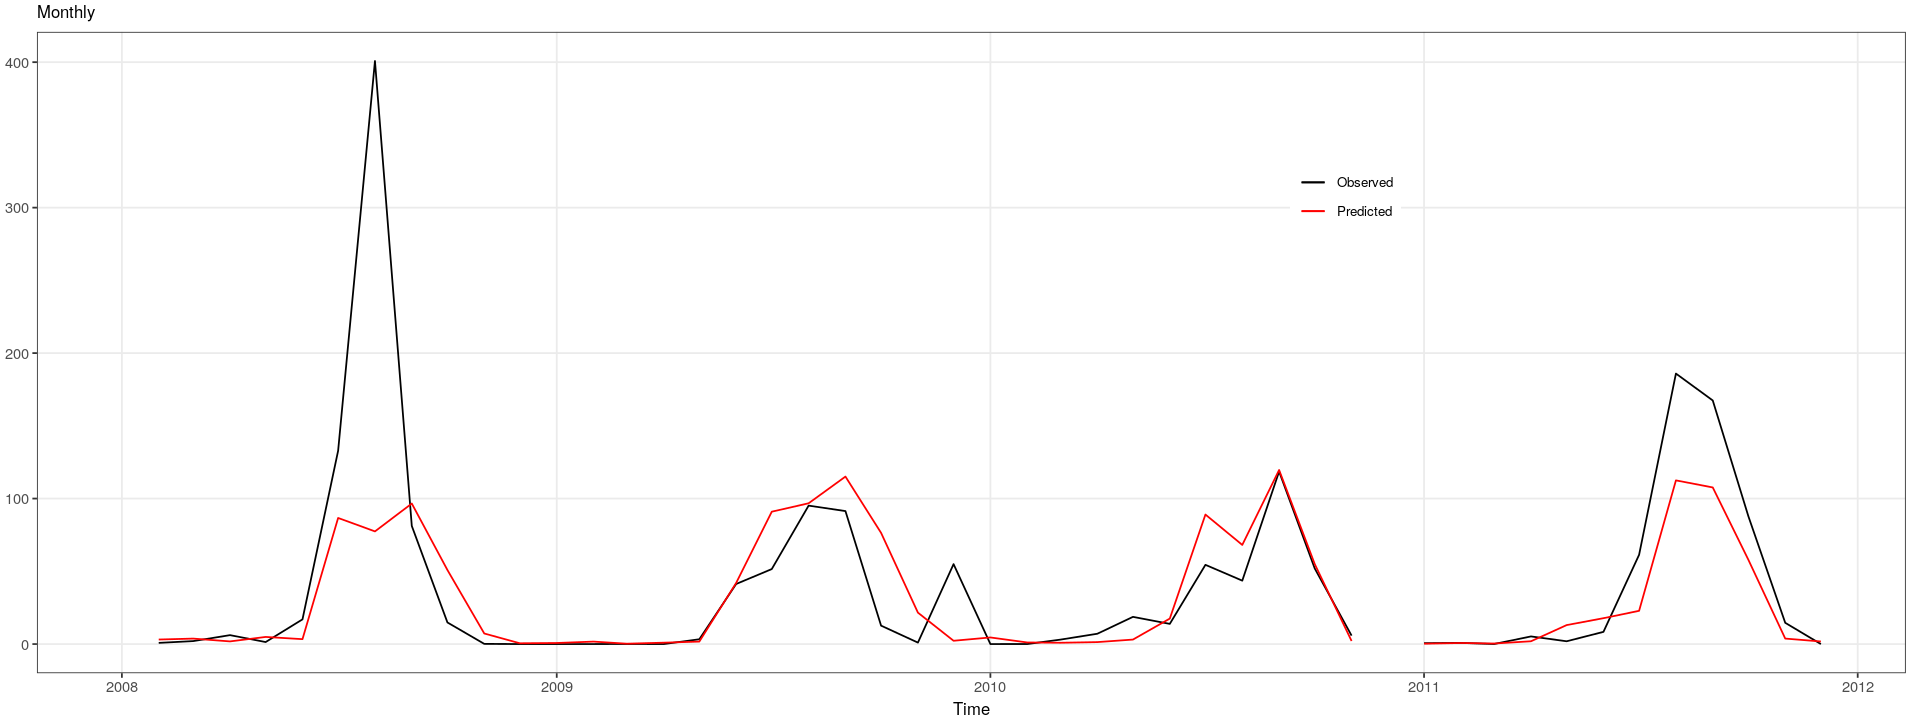

In [15]:
month_plot

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


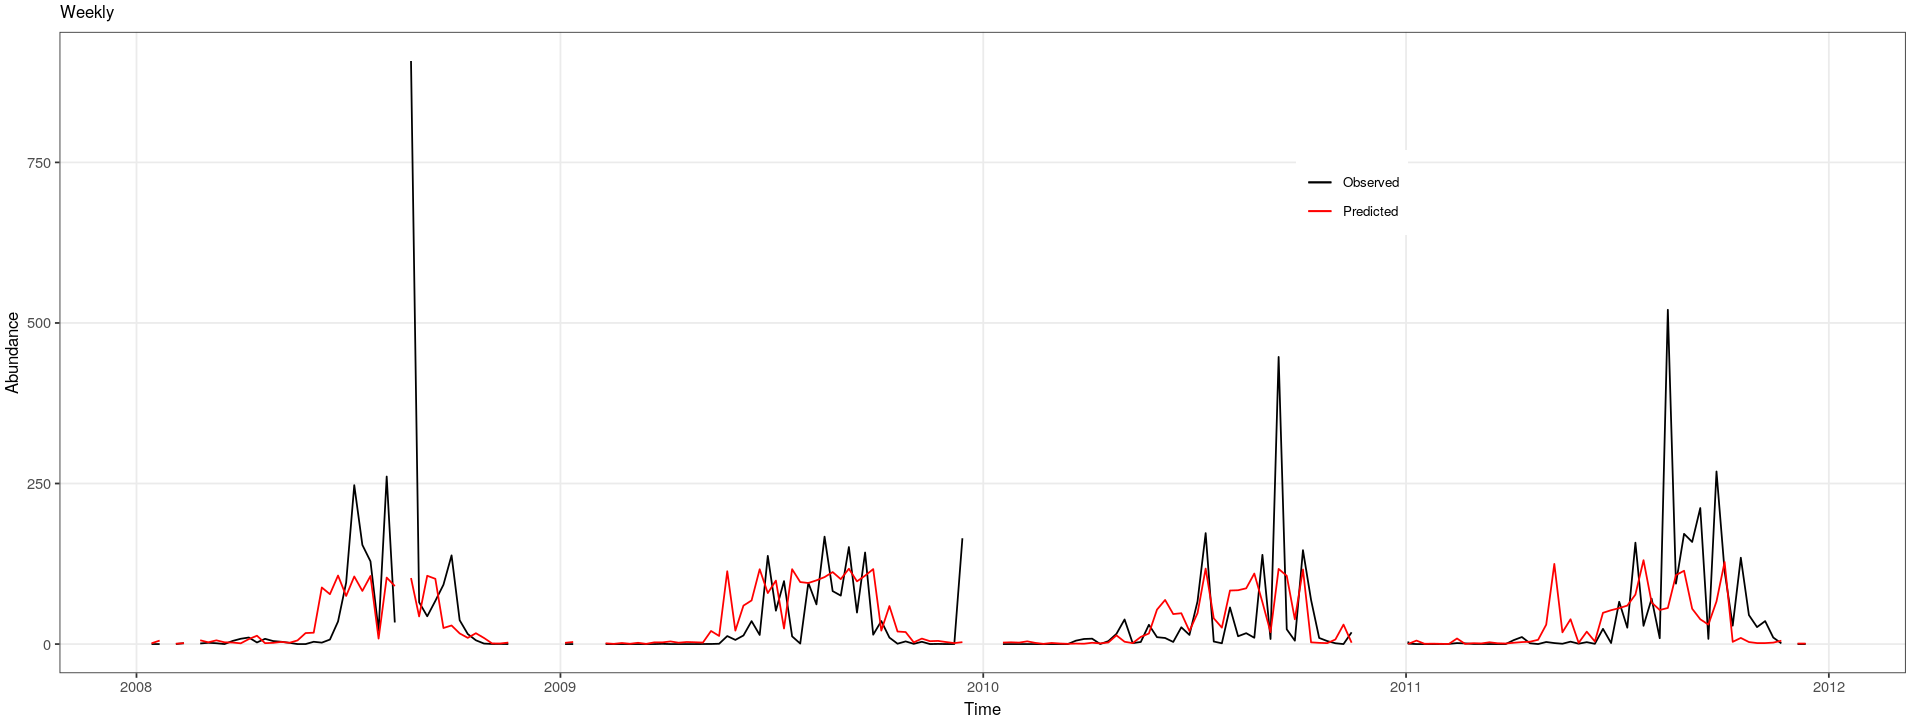

In [16]:
week_plot

The stochasticity in monthly data is smoothed, so predictions are more likely to capture these less stochastic trends. Moving forward, I will use monthly data only in analysis of model characteristics across locations since I would recommend this resolution for early warning models. 

## Question 2: Applicability of Model Characteristics across locations

I will restrict my analysis to species that occur in all five locations in order to assess how similar model characteristics (lag lengths and significance of meterogological variables) is across locations. This is important because for early warning models to be helpful in reducing reliance on resource-heavy surveillance programs, models should ideally be applicable across locations without location-specific parameterisation.

In [17]:
compare_specs = which(monthly$Location == "Lee")

counts = data.frame(table(monthly$Species))
colnames(counts) = c("Species", "Counts")

counts = counts[which(counts$Counts > 1),]
cat(nrow(counts), " species with greater than 1 occurance")
table(counts$Counts)

27  species with greater than 1 occurance


 2  3  4  5 
 7  2  8 10 

In [18]:
# Prepare Multi_SignifVariables column for plotting

# Change NAs in SignifVariables to Neither
monthly$Multi_SignifVariables = replace(monthly$Multi_SignifVariables, 
                                        is.na(monthly$Multi_SignifVariables), "Neither")

# Change both temp and precip to "Both"
monthly$Multi_SignifVariables = replace(monthly$Multi_SignifVariables, 
                                        nchar(monthly$Multi_SignifVariables) > 7, "Both")

# Convert significant variables to factor and put in order
monthly$Multi_SignifVariables = factor(monthly$Multi_SignifVariables, 
                                       levels  = c("temp", "precip", "Both", "Neither"))
# Convert significant variables to factor and put in order
monthly$Best_Precip = factor(monthly$Best_Precip, 
                             levels  = c("precip_lag2", "precip_lag1", "precip_lag0"))

monthly$Best_Temp = factor(monthly$Best_Temp, 
                           levels  = c("temp_lag2", "temp_lag1", "temp_lag0"))


In order to have some decent comparison, I want to restrict to species that occur in all of my sites. Let's see what these are:

In [19]:
# Find species which occur in all five locations
focal = monthly %>%
  group_by(Species) %>% filter(n() > 4)

# Print these species names
unique(focal$Species)

[1] "Aedes.albopictus"                          
 [2] "Aedes.infirmatus"                          
 [3] "Anopheles.quadrimaculatus"                 
 [4] "Culex.nigripalpus"                         
 [5] "Culiseta.melanura"                         
 [6] "Psorophora.ciliata"                        
 [7] "Psorophora.columbiae"                      
 [8] "Psorophora.ferox"                          
 [9] "C.pipiens.morphological.group"             
[10] "A.atlanticus.tormentor.morphological.group"

### Create plots of temperature and precipitation lags across locations


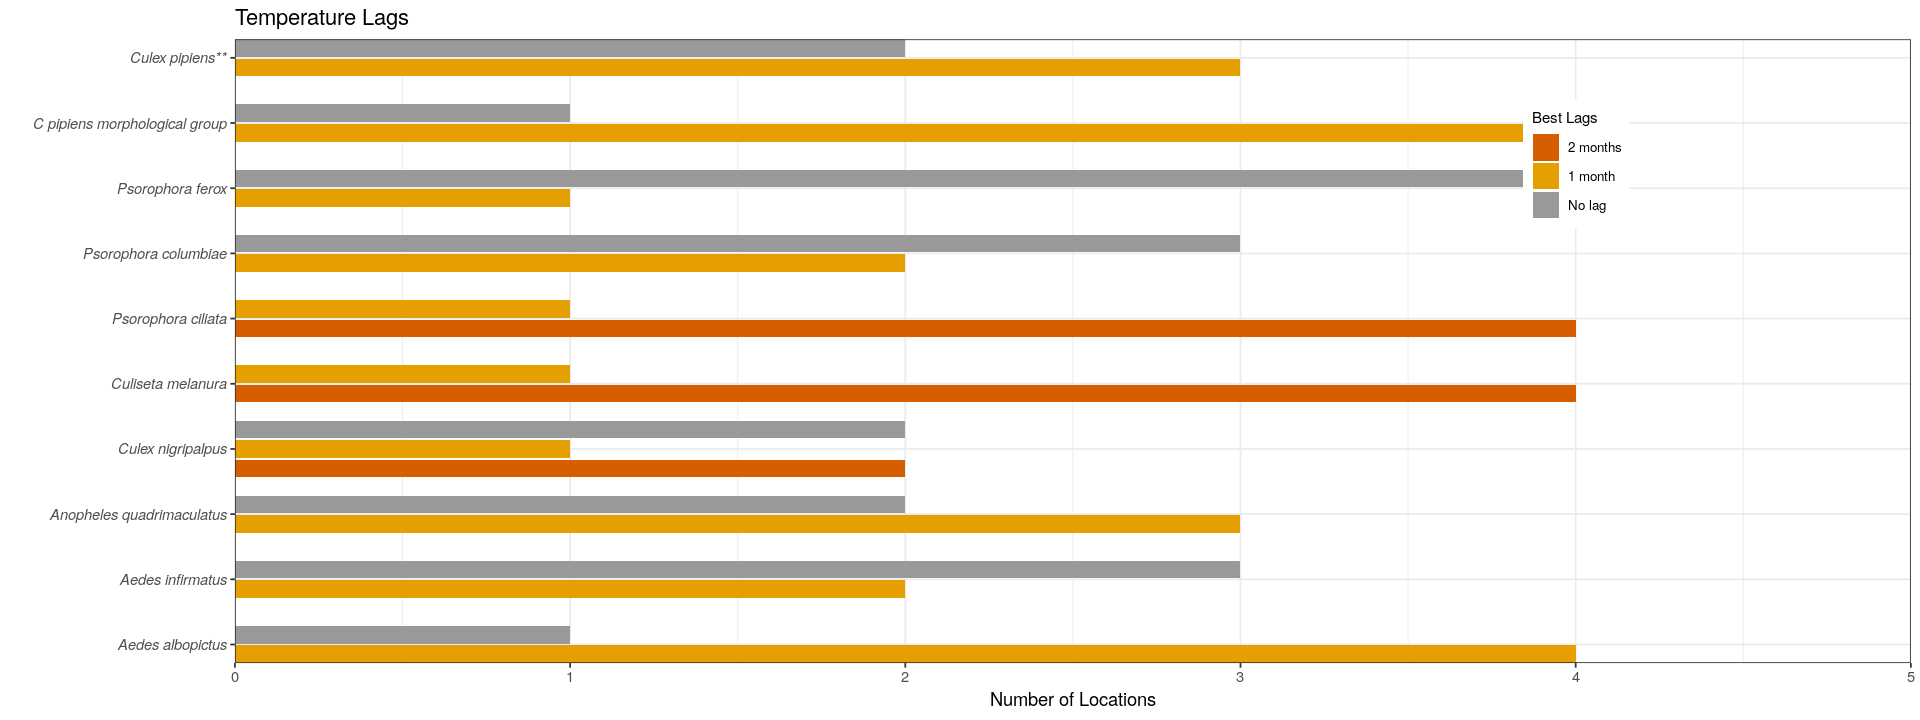

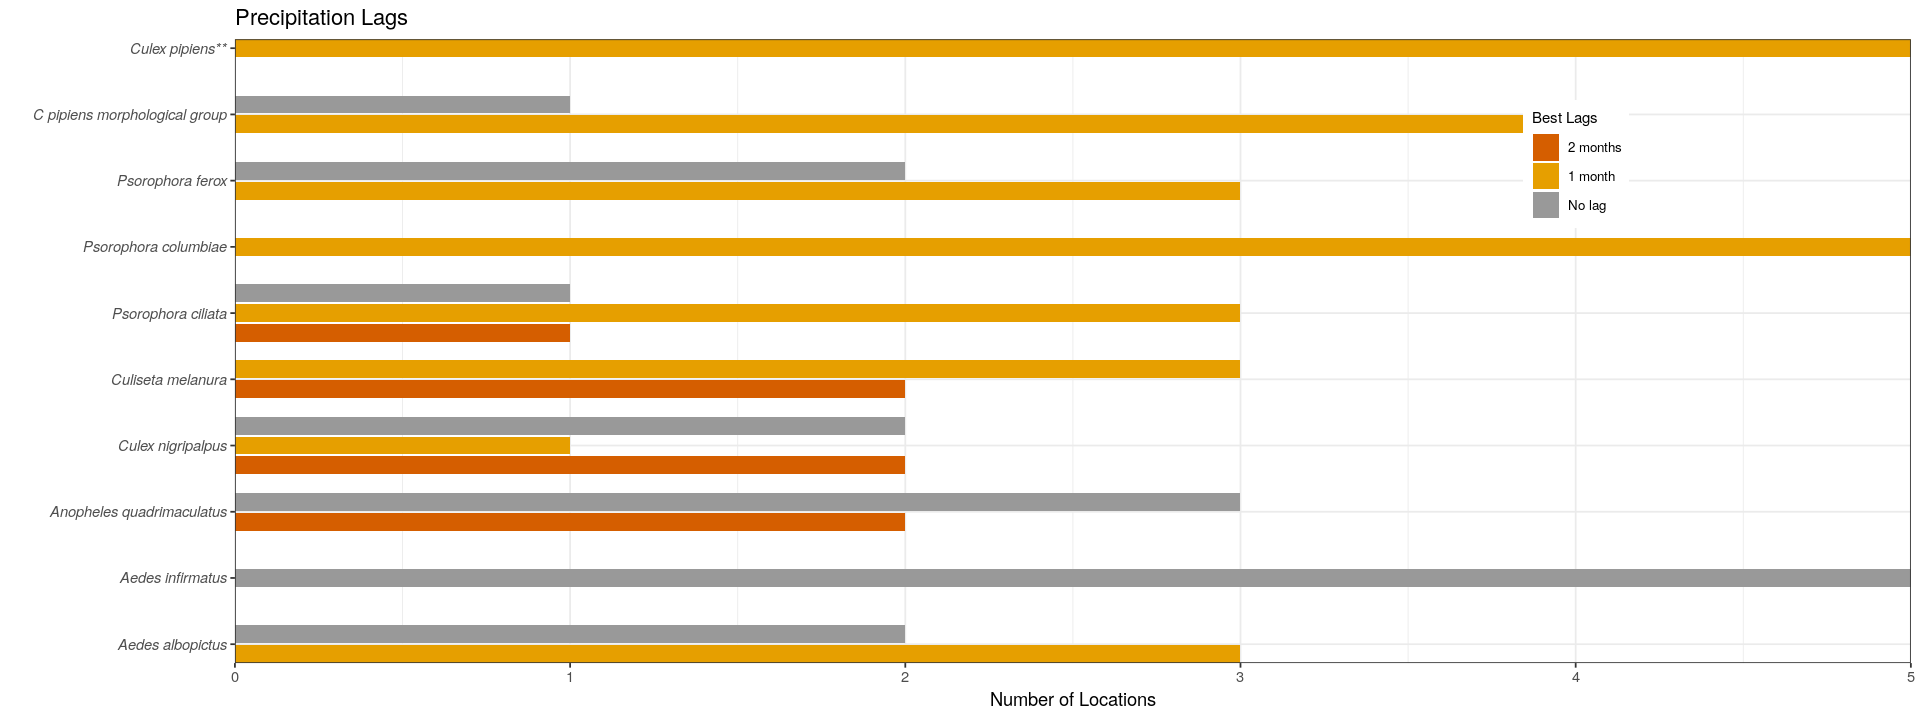

In [20]:
my_labels = gsub("\\.", " ", unique(focal$Species))
my_labels[10:11] = c("Culex pipiens**", "Aedes atlanticus**")

temp_plot = ggplot(focal, aes(x = Species, fill = Best_Temp)) + ggtitle("Temperature Lags") +
  geom_bar(position = position_dodge2(width = 2, preserve = "single")) + coord_flip(expand = FALSE) + ylab("Number of Locations") + xlab("") +
  scale_fill_manual(values=c(cbPalette[7], cbPalette[2], cbPalette[1]), 
                    labels = c("2 months", "1 month", "No lag"), 
                    name = "Best Lags") + theme_bw() + 
  theme(legend.position = c(0.8,0.8), 
        axis.text.y = element_text(face = "italic"), legend.text = element_text(size = 8),
        plot.subtitle = element_text("** species complex"), legend.title = element_text(size = 9)) +
  scale_x_discrete(labels = my_labels) + scale_y_continuous(limits = c(0,5))
temp_plot

precip_plot = ggplot(focal, aes(x = Species, fill = Best_Precip)) + ggtitle("Precipitation Lags") +
  geom_bar(position = position_dodge2(width = 2, preserve = "single")) + coord_flip(expand = FALSE) + ylab("Number of Locations") + xlab("") +
  scale_fill_manual(values=c(cbPalette[7], cbPalette[2], cbPalette[1]), 
                    labels = c("2 months", "1 month", "No lag"), 
                    name = "Best Lags") + theme_bw() + 
  theme(legend.position = c(0.8,0.8), 
        axis.text.y = element_text(face = "italic"), legend.text = element_text(size = 8),
        plot.subtitle = element_text("** species complex"), legend.title = element_text(size = 9)) +
  scale_x_discrete(labels = my_labels) + scale_y_continuous(limits = c(0,5))
precip_plot

Most of these species have a lag length for temperature and a lag length for precipitation that is selected in a *majority* of locations, but few have lag lengths that are chosen 100% consistantly across locations. Let's have a look a variable significance:

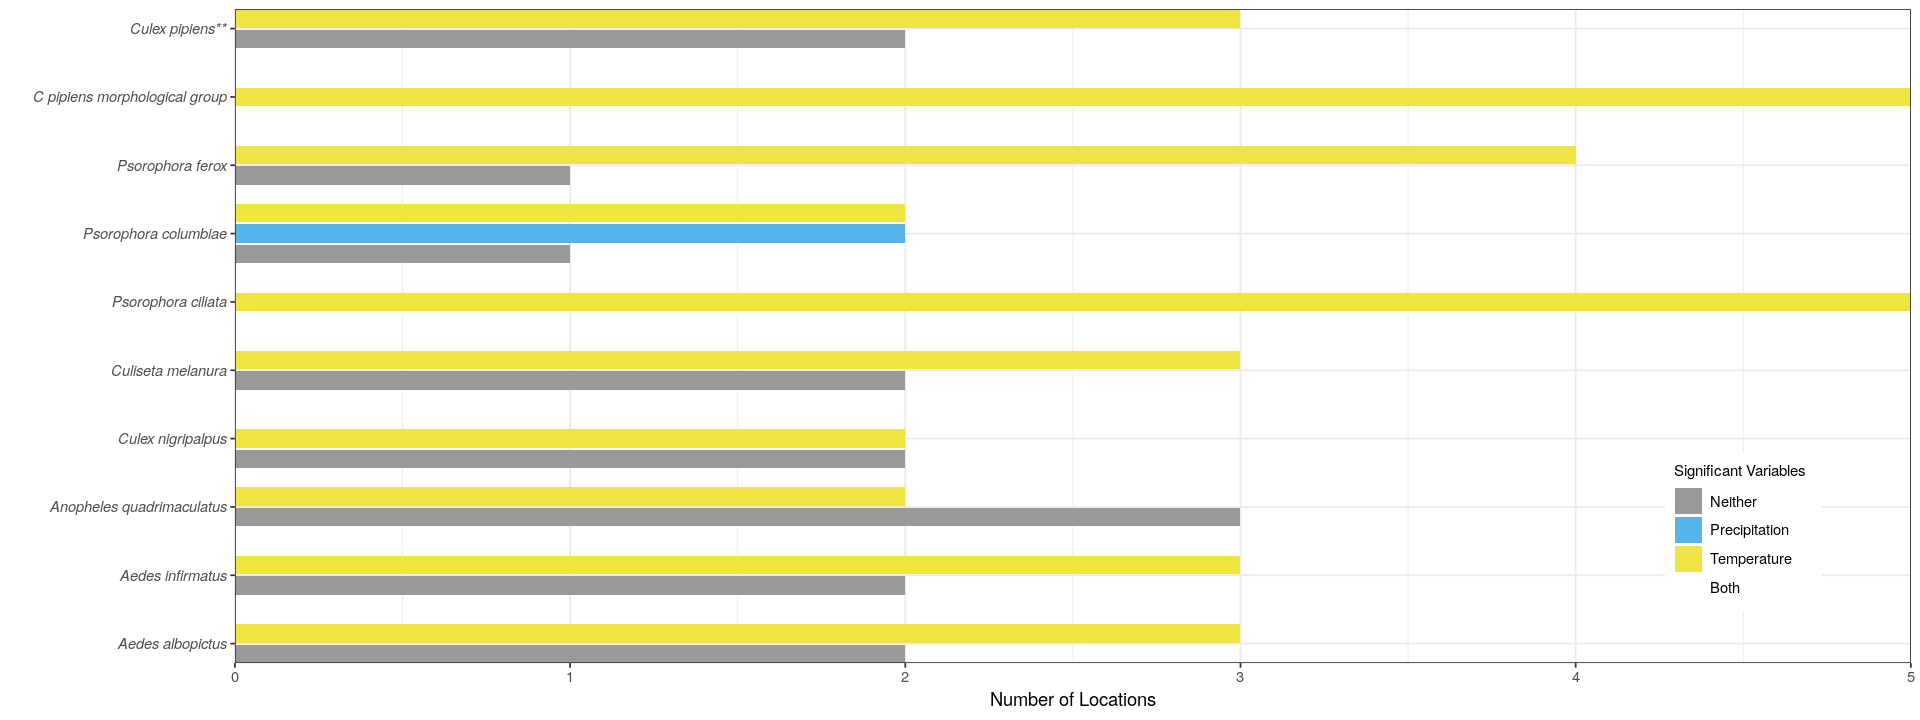

In [21]:
my_labels = gsub("\\.", " ", unique(focal$Species))
my_labels[10:11] = c("Culex pipiens**", "Aedes atlanticus**")
ggplot(focal, aes(x = Species, fill = Multi_SignifVariables)) + 
  geom_bar(position = position_dodge2(width = 2, preserve = "single")) + coord_flip(expand = FALSE) + ylab("Number of Locations") + xlab("") +
  scale_fill_manual(values=c(cbPalette[1], cbPalette[3], cbPalette[5], cbPalette[4]), 
                    labels = c("Neither", "Precipitation", "Temperature", "Both"), 
                    name = "Significant Variables") + theme_bw() + 
  theme(legend.position = c(0.9,0.2), 
        axis.text.y = element_text(face = "italic"), 
        plot.subtitle = element_text("** species complex"), legend.title = element_text(size = 9)) +
  scale_x_discrete(labels = my_labels) + scale_y_continuous(limits = c(0,5))

Same finding with significant variables- in many cases, there is a majority "category" of significant variable that is consistant across locations, but there are few cases where the exact same collection of variables are significant across all locations.


## Other interesting information: lag frequencies, temperature ranges, etc

In [22]:
# Find precip lags at each resolution

cat("\n\nWeekly precip lags: \n --------------------------------------------------- \n")
table(weekly$Best_Precip)

cat("\n\n Bimonthly precip lags: \n --------------------------------------------------- \n")
table(biweekly$Best_Precip)

cat("\n\n Monthly precip lags: \n --------------------------------------------------- \n")
table(monthly$Best_Precip)



Weekly precip lags: 
 --------------------------------------------------- 



 precip_lag0  precip_lag1 precip_lag10 precip_lag11 precip_lag12  precip_lag2 
           8           11            5           13           12           15 
 precip_lag3  precip_lag4  precip_lag5  precip_lag6  precip_lag7  precip_lag8 
           9            9            9            8            5            3 
 precip_lag9 
           3 



 Bimonthly precip lags: 
 --------------------------------------------------- 



precip_lag0 precip_lag1 precip_lag2 precip_lag3 precip_lag4 precip_lag5 
         28          31          16          10          11          14 



 Monthly precip lags: 
 --------------------------------------------------- 



precip_lag2 precip_lag1 precip_lag0 
         27          45          38 

In [23]:

cat("\n\n Weekly temp lags: \n --------------------------------------------------- \n")
table(weekly$Best_Temp)

cat("\n\n Bimonthly temp lags: \n --------------------------------------------------- \n")
table(biweekly$Best_Temp)

cat("\n\n Monthly temp lags: \n --------------------------------------------------- \n")
table(monthly$Best_Temp)



 Weekly temp lags: 
 --------------------------------------------------- 



 temp_lag0  temp_lag1 temp_lag10 temp_lag11 temp_lag12  temp_lag2  temp_lag3 
        23          6          4         11          8         15          9 
 temp_lag4  temp_lag5  temp_lag6  temp_lag7  temp_lag8  temp_lag9 
        10          4          4          6          4          6 



 Bimonthly temp lags: 
 --------------------------------------------------- 



temp_lag0 temp_lag1 temp_lag2 temp_lag3 temp_lag4 temp_lag5 
       33        24        18         9        12        14 



 Monthly temp lags: 
 --------------------------------------------------- 



temp_lag2 temp_lag1 temp_lag0 
       19        42        49 

In [24]:
## Calculate Akaike weights

print(summary(weekly$AIC_wt_temp))
print(summary(weekly$AIC_wt_precip))

print(summary(biweekly$AIC_wt_temp))
print(summary(biweekly$AIC_wt_precip))

print(summary(monthly$AIC_wt_temp))
print(summary(monthly$AIC_wt_precip))

cat("\nAverage median temperature lag confidence = ", mean(c(median(monthly$AIC_wt_temp), 
                                                      median(biweekly$AIC_wt_temp),
                                                     median(weekly$AIC_wt_temp))))

cat("\nAverage median precipitation lag confidence = ", mean(c(median(monthly$AIC_wt_precip), 
                                                      median(biweekly$AIC_wt_precip),
                                                     median(weekly$AIC_wt_precip))))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.30   68.97   89.35   80.07   99.00  100.00 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  13.90   53.83   82.40   75.00   99.35  100.00 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  23.30   67.38   88.30   80.71   99.33  100.00 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  24.20   70.22   87.45   80.65   98.83  100.00 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  34.90   73.97   95.10   85.34   99.70  100.00 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  33.80   65.83   90.75   82.57   99.60  100.00 

Average median temperature lag confidence =  90.91667
Average median precipitation lag confidence =  86.86667

In [25]:
# Find temperature ranges

ranges = vector("list", 5)
names(ranges) = locations

for(i in 1:length(locations)){
    weekly_ts = read.csv(paste0("../Data/Extracted_Data/Aggregated/", locations[i], "_weekly.csv"), header = T, stringsAsFactors = F)
    ranges[[i]] = c(range(weekly_ts$temp_mean), diff(range(weekly_ts$temp_mean)))
}

print(ranges)

$Lee
[1] 14.28816 34.91221 20.62405

$Manatee
[1] 18.38263 34.37219 15.98956

$Orange
[1] 17.98406 35.32719 17.34313

$Saint_Johns
[1]  8.466605 35.805016 27.338412

$Walton
[1] 11.48445 35.57372 24.08926



In [26]:
### Count the total number of GAMs fitted for this analysis- just for fun!

total = sum(weekly$Multi_Blocks, na.rm = TRUE) + sum(biweekly$Multi_Blocks, na.rm = TRUE) + 
sum(monthly$Multi_Blocks, na.rm = TRUE) + # sum the number of models fit during cross validation 
111*(13)*2 + 129*(3)*2 + 119*(6)*2 + # Sum the number of univariate models for each resolution
111 + 129 + 119 # Sum the number of multivariate models

cat("\n There are ", total, " total GAMs fitted each time the gam_batch.R analysis is run")


 There are  7893  total GAMs fitted each time the gam_batch.R analysis is run